In [ ]:
import nbformat

path = "/content/your_notebook.ipynb"  # change this if your file name differs

nb = nbformat.read(path, as_version=4)

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]
    nbformat.write(nb, path)
    print("✅ Fixed: removed invalid 'widgets' metadata.")
else:
    print("No 'widgets' metadata found — nothing to fix.")


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Md Rasel Uddin - Task Assignment – AI/ML Engineer Position at Backbencher Studio

Step 1 – Data Preparation

In [ ]:
# Importing the necessary libraies

import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split

# Loading the dataset using Pandas

# As no header name in CSV, so specifying the columns
df = pd.read_csv('/content/drive/MyDrive/bb/train_data.csv', header=None, names=['review','label'])
print("Dataset shape:", df.shape)

# Dropping the first row, which is 0 and 1
df = df.drop(index=0).reset_index(drop=True)
df.head(10)


Dataset shape: (25001, 2)


,review,label
0,"This film is absolutely awful, but nevertheles...",0
1,Well since seeing part's 1 through 3 I can hon...,0
2,I got to see this film at a preview and was da...,1
3,This adaptation positively butchers a classic ...,0
4,Råzone is an awful movie! It is so simple. It ...,0
5,"Firstly, this is simply the funniest movie I h...",1
6,The first hour of the movie was boring as hell...,0
7,I read Tom Robbins' EVEN COWGIRLS GET THE BLUE...,0
8,I waited for this movie to play in great antic...,0
9,I actually felt bad for the actors in this thi...,0


In [ ]:
# Cleaning the text: remove HTML tags, remove punctuation, numbers, lower-case

def clean_text(text):
    # Remove HTML tags (such as <br />)
    text = re.sub(r'<.*?>', '', text)
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Apply cleaning and storing in a new column
df['review_clean'] = df['review'].apply(clean_text)

# Remove stopwords using NLTK
try:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
except Exception as e:
    # If NLTK stopwords not available, define a small list manually
    stop_words = set(["the","and","is","in","to","of","it","a","for","this","that","with","as","an","on","at","by"])

df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

# Final dataset shape and class balance
print(df['label'].value_counts())


label
0    12500
1    12500
Name: count, dtype: int64


In [ ]:
# Spliting the dataset into Train and test (80/20)
X = df['review_clean']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 20000 Test size: 5000


Step 2 – Model Training

In [ ]:
# Converting text to features using TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorizer (1-2 grams, max 20k features)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print("TF-IDF shape:", X_train_tfidf.shape)


TF-IDF shape: (20000, 20000)


In [ ]:
# Using Logistic Regression, Naive Bayes, or Random Forest ML model for classification.

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Optimize model parameters for better accuracy

# Hyperparameter grids
grid_lr = {'C': [0.01, 0.1, 1, 10]}
grid_nb = {'alpha': [0.5, 1.0, 1.5]}
grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}

# Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr = GridSearchCV(lr, grid_lr, cv=5, scoring='accuracy')
clf_lr.fit(X_train_tfidf, y_train)
print("Best LR params:", clf_lr.best_params_)

# Naive Bayes
nb = MultinomialNB()
clf_nb = GridSearchCV(nb, grid_nb, cv=5, scoring='accuracy')
clf_nb.fit(X_train_tfidf, y_train)
print("Best NB params:", clf_nb.best_params_)

# # Random Forest
rf = RandomForestClassifier(random_state=42)
clf_rf = GridSearchCV(rf, grid_rf, cv=5, scoring='accuracy')
clf_rf.fit(X_train_tfidf, y_train)
print("Best RF params:", clf_rf.best_params_)


Best LR params: {'C': 10}
Best NB params: {'alpha': 0.5}
Best RF params: {'max_depth': None, 'n_estimators': 200}


Step 3 – Evaluation


Logistic Regression: Accuracy = 0.892, Precision = 0.895, Recall = 0.888, F1-score = 0.892
Naive Bayes: Accuracy = 0.872, Precision = 0.876, Recall = 0.865, F1-score = 0.871
Random Forest: Accuracy = 0.852, Precision = 0.864, Recall = 0.837, F1-score = 0.850

Confusion Matrix (Logistic Regression):
 [[2241  259]
 [ 281 2219]]


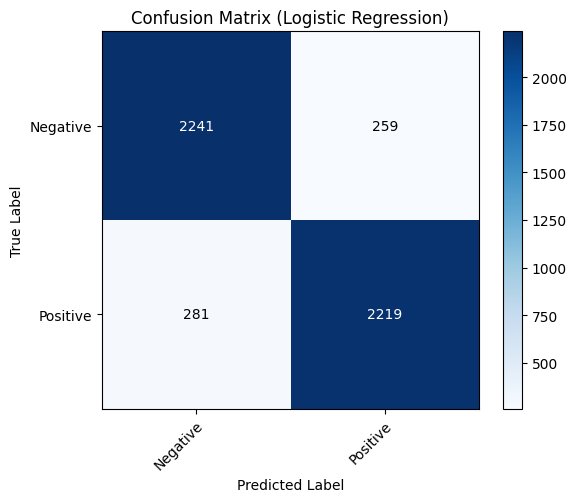

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Evaluate on test set
models = {
    'Logistic Regression': clf_lr.best_estimator_,
    'Naive Bayes': clf_nb.best_estimator_,
    'Random Forest': clf_rf.best_estimator_
}
# Train and evaluate the model on the test set
results = []
for name, model in models.items():
    pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    results.append((name, acc, prec, rec, f1))
    print(f"{name}: Accuracy = {acc:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, F1-score = {f1:.3f}")

# Confusion matrix for Logistic Regression (best-performing)
cm = confusion_matrix(y_test, models['Logistic Regression'].predict(X_test_tfidf))
print("\nConfusion Matrix (Logistic Regression):\n", cm)

labels = ["Negative", "Positive"]

# Matplotlib visualization for the Confusion matrix for Logistic Regression (best-performing)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set ticks and labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel="True Label",
    xlabel="Predicted Label",
    title="Confusion Matrix (Logistic Regression)"
)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with the numeric value
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


*Saving the trained models as .pkl*

In [ ]:
import joblib
best_model = models['Logistic Regression']
joblib.dump(best_model, 'best_model_lr.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

**Step 4 – Bonus (Optional)  Deep Learning model.**

In [ ]:
!pip install -U transformers datasets
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 86.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0


In [ ]:
import transformers
print(transformers.__version__)

4.55.1


In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from transformers import TrainingArguments
import os
os.environ["WANDB_DISABLED"] = "true"
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Prepare HuggingFace dataset from pandas
train_ds = Dataset.from_pandas(pd.DataFrame({'text': X_train, 'label': y_train}))
test_ds = Dataset.from_pandas(pd.DataFrame({'text': X_test, 'label': y_test}))

# Tokenizer and model initialization
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenization function
def preprocess(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=256)
train_ds = train_ds.map(preprocess, batched=True)
test_ds = test_ds.map(preprocess, batched=True)

# Set format for PyTorch
train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir='distilbert_sentiment',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, eval_dataset=test_ds, tokenizer=tokenizer, compute_metrics=compute_metrics )

# Fine-tune
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2000758753.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, train_dataset=train_ds, eval_dataset=test_ds, tokenizer=tokenizer, compute_metrics=compute_metrics )


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.252100,0.275267,0.891800,0.924577,0.853200,0.887456
2,0.178500,0.314882,0.902600,0.928845,0.872000,0.899525
3,0.065300,0.445177,0.910000,0.916667,0.902000,0.909274
4,0.030000,0.521646,0.903400,0.897830,0.910400,0.904071
5,0.019500,0.612640,0.905200,0.909128,0.900400,0.904743


TrainOutput(global_step=6250, training_loss=0.12240062527656555, metrics={'train_runtime': 2437.2212, 'train_samples_per_second': 41.03, 'train_steps_per_second': 2.564, 'total_flos': 6623369932800000.0, 'train_loss': 0.12240062527656555, 'epoch': 5.0})

In [ ]:
# Evaluate on test set
preds = trainer.predict(test_ds)
preds_labels = np.argmax(preds.predictions, axis=1)
accuracy = accuracy_score(y_test, preds_labels)
print("DistilBERT Test Accuracy:", accuracy)


DistilBERT Test Accuracy: 0.91


In [ ]:
# Save tokenizer and model (HuggingFace format)
tokenizer.save_pretrained('distilbert_tokenizer')
model.save_pretrained('distilbert_model')


CLI Demo Script

In [ ]:
import joblib
from transformers import pipeline

# Load both models once for speed
clf = joblib.load('best_model_lr.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
classifier = pipeline("sentiment-analysis", model="distilbert_model", tokenizer="distilbert_tokenizer")

print("Enter 'quit' to stop reviewing.")

while True:
    review = input("\nEnter movie review: ")
    if review.lower() == "quit":
        print("Exiting...")
        break

    # Ask which model to use for this review
    model_choice = input("Choose model (ml = Logistic Regression, dl = DistilBERT): ").strip().lower()

    if model_choice == "ml":
        vect = tfidf.transform([review])
        pred = clf.predict(vect)[0]
        sentiment = "Positive" if pred == 1 else "Negative"
        print(f"Prediction (Logistic Regression): {sentiment} (label={pred})")

    elif model_choice == "dl":
        result = classifier(review[:512])[0]
        sentiment = "Positive" if result['label'].upper() == "POSITIVE" else "Negative"
        print(f"Prediction (DistilBERT): {sentiment} (label={result['label']})")

    else:
        print("Invalid choice. Please type 'ml' or 'dl'.")




Device set to use cuda:0


Enter 'quit' to stop reviewing.

Enter movie review: This movie was fantastic! I loved every minute of it.
Choose model (ml = Logistic Regression, dl = DistilBERT): ml
Prediction (Logistic Regression): Positive (label=1)

Enter movie review: I hated this movie. It was boring and too long
Choose model (ml = Logistic Regression, dl = DistilBERT): dl
Prediction (DistilBERT): Negative (label=LABEL_0)

Enter movie review: The cinematography was nice, but the story was weak
Choose model (ml = Logistic Regression, dl = DistilBERT): ml
Prediction (Logistic Regression): Negative (label=0)

Enter movie review: It was okay, some parts were good, but the ending was disappointing.
Choose model (ml = Logistic Regression, dl = DistilBERT): quit
Invalid choice. Please type 'ml' or 'dl'.

Enter movie review: It was okay, some parts were good, but the ending was disappointing.
Choose model (ml = Logistic Regression, dl = DistilBERT): dl
Prediction (DistilBERT): Negative (label=LABEL_0)

Enter movie revi

Deploying using StreamLit

I have deployed the model using streamlit in another file named streamlit_app.py in the same folder. Please see that. Thank you.